In [136]:
from fxpmath import Fxp

In [137]:
ALL = Fxp(None, signed=True, n_word=16, n_frac=8, overflow='saturate')

In [138]:
import numpy as np

In [139]:
def padones(x):
    padded_array = Fxp(np.ones((x.shape[0], x.shape[1] + 1))).like(ALL)
    padded_array[:, : x.shape[1]] = x
    return padded_array

In [140]:
class Linear:
    def __init__(self, num_in, num_out, use_bias = True) -> None:
        self.use_bias = use_bias
        self.num_in = num_in
        self.num_out = num_out
        self.matr = Fxp(np.random.normal(0, 1., (num_in + (1 if use_bias else 0), num_out))).like(ALL)
        self.grads = np.zeros_like(self.matr)
        self.last_xs = None

    def get_grad(self, upstream_resp_loss: np.ndarray) -> np.ndarray:
        # divvy up the blame!
        # except now, just do it with the last inputs

        # the loss 'attributed' that we will pass up, (the loss 'attributed' to inputs) is proportonial to the weight mat
        if not self.use_bias:
            dloss_din = np.matmul(upstream_resp_loss, self.matr.T).like(ALL)
            # dloss_din = upstream_resp_loss @ self.matr.T
        else:
            # chop off the bias!
            dloss_din = np.matmul(upstream_resp_loss, self.matr[:-1, :].T).like(ALL)
            # dloss_din = upstream_resp_loss @ self.matr[:-1, :].T

        # the loss 'attributed' to the weights is directly proportional to the inputs we recieved
        dloss_dweights = np.matmul(self.last_xs.T, upstream_resp_loss).like(ALL)
        # dloss_dweights = self.last_xs.T @ upstream_resp_loss

        assert self.grads.shape == dloss_dweights.shape
        self.grads = dloss_dweights

        return dloss_din

    def forward(self, xs: np.ndarray, no_record: bool = False) -> np.ndarray:
        # fix xs, if we need bias
        fixed_xs = xs
        # print(f"{fixed_xs.shape=}")
        if self.use_bias:
            fixed_xs = padones(fixed_xs)
            # fixed_xs = np.hstack((fixed_xs, Fxp(np.ones((fixed_xs.shape[0], 1)))))
        
        if not no_record:
            self.last_xs = fixed_xs
        
        # return self.last_xs @ self.matr
        # print(f"{self.matr=}")
        return np.matmul(fixed_xs, self.matr).like(ALL)

In [141]:
class LinearPercepFused(Linear):
    def forward(self, xs: np.ndarray, no_record: bool = False) -> np.ndarray:
        outp = super().forward(xs, no_record)
        return np.where(outp > 0., Fxp(0), Fxp(1)).like(ALL)

In [142]:
class MSELoss:
    def __init__(self) -> None:
        self.last_diffs = None

    def get_grad(self) -> np.ndarray:
        return self.last_diffs/len(self.last_diffs) << 1

    def forward(self, y: np.ndarray, y_exp) -> np.ndarray:
        self.last_diffs = y - y_exp
        return np.mean((self.last_diffs**2))

In [143]:
# matr = np.random.normal(0, 1., (1 + (1 if True else 0), 10))

In [144]:
# matr.shape

In [145]:
# matr[:-1, :].shape

In [146]:
# (2.*np.ones((10, 1))) @ matr[:-1, :]

In [147]:
# (2.*np.ones((10, 1))) @ matr[:-1, :] + matr[-1, :]

In [148]:
# tx = 2.*np.ones((10, 1))
# np.hstack((tx, np.ones((tx.shape[0], 1)))) @ matr

In [149]:
# fixed_xs = Fxp(np.random.normal(0, 1., size=5).reshape(-1, 1)).like(ALL)
# print(f"{fixed_xs=}")
# np.where(fixed_xs > 0., Fxp(0), Fxp(1)).like(ALL)

In [150]:
# from fxpmath import Fxp
# import numpy as np

# ALL = Fxp(None, signed=True, n_word=16, n_frac=8)
# fixed_xs = Fxp(np.ones((4, 1))).like(ALL)
# np.hstack((fixed_xs, Fxp(np.ones((fixed_xs.shape[0], 1))).like(ALL)))

In [151]:
# l = Linear(1, 1)

In [152]:
xs = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
ys = np.array([[0.], [1.], [1.], [0.]])

xs_repeat = xs.repeat(10, 0)
ys_repeat = ys.repeat(10, 0)
ys_repeat += np.random.normal(0, .01, size=ys_repeat.shape)

fxp_xs = Fxp(xs_repeat).like(ALL)
fxp_ys = Fxp(ys_repeat).like(ALL)

In [153]:
# Linear(1, 1).matr.config.op_input_size

In [154]:
# weird matmul behavior!!
# wm = Fxp(np.random.normal(0, 1., size=(1, 1))).like(ALL)
# print(f"{np.matmul(Fxp(np.ones((10, 1))).like(ALL), wm)=}")
# print(f"{np.dot(Fxp(np.ones((10, 1))).like(ALL), wm)=}")

In [155]:
def get_random_range(lenx, seq_len):
    start_i = np.random.randint(0, lenx-seq_len)
    return start_i, start_i + seq_len

In [156]:
from tqdm import tqdm

In [157]:
LR_FAC = 4
lin1 = LinearPercepFused(2, 5, use_bias=True)
lin2 = LinearPercepFused(5, 1, use_bias=True)
lossf = MSELoss()

losses = []
for _ in tqdm(range(3000)):
    starti, endi = get_random_range(len(fxp_xs), 1)
    out_l1 = lin1.forward(fxp_xs[starti:endi])
    out = lin2.forward(out_l1)

    loss = lossf.forward(out, fxp_ys[starti:endi])
    # print(f"{loss=}")
    
    pass_back_grad = lossf.get_grad()
    pass_back_grad = lin2.get_grad(pass_back_grad)
    pass_back_grad = lin1.get_grad(pass_back_grad)

    lin1.matr += lin1.grads >> LR_FAC
    # lin1.matr += lin1.grads *.01

    lin2.matr += lin2.grads >> LR_FAC
    # lin2.matr += lin2.grads *.01
    losses.append(loss)

 33%|███▎      | 1004/3000 [00:07<00:15, 127.00it/s]


OverflowError: int too large to convert to float

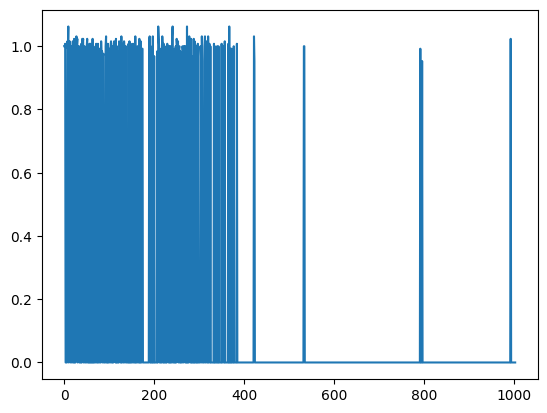

In [158]:
import matplotlib.pyplot as plt
plt.plot(losses)

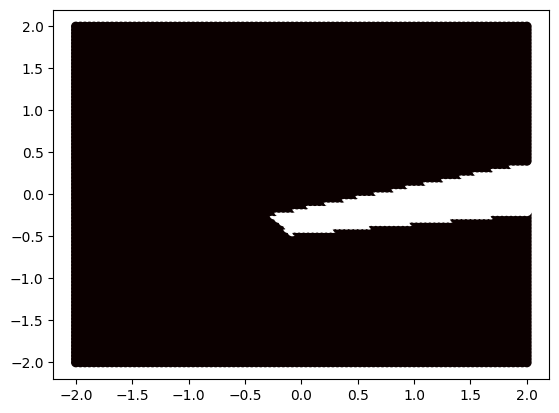

In [ ]:
sxs, sys = np.meshgrid(*[np.linspace(-2, 2, 101) for _ in range(2)])
pts = np.vstack([sxs.ravel(), sys.ravel()]).T
out_l1 = lin1.forward(pts, True)
out = lin2.forward(out_l1, True)
plt.scatter(pts[:, 0], pts[:, 1], c=out, cmap="hot")

In [159]:
out_l1 = lin1.forward(Fxp(xs).like(ALL), True)
out = lin2.forward(out_l1, True)
out

fxp-s16/8([[0.]
           [1.]
           [1.]
           [0.]])

In [ ]:
ys

array([[0.],
       [0.],
       [1.],
       [0.]])